In [1]:

import pandas as pd
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import linregress
import seaborn as sns
import sqlite3
from sqlite3 import IntegrityError
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
import logging
import time
from concurrent.futures import ThreadPoolExecutor
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import logging
import datapane as dp
import altair as alt

# Problem Statement 1 : Data Cleaning and Augmentation

In [ ]:
"""-   Problem Statement 1:   Identify and handle missing values using advanced imputation techniques. Correct anomalies by identifying outliers using statistical methods and domain knowledge. Standardize data formats and ensure consistency across the dataset. Augment the dataset by generating synthetic data using data augmentation techniques and collecting additional data from public sports databases. Integrate this data into a unified dataset.
   -   Additional Complexity:   Implement data validation scripts to automate the data cleaning process.
"""

In [3]:
data = pd.read_csv('Sports dataset.csv')
impute_data = data[['Age', 'Height', 'Weight']].copy()
imputer = KNNImputer(n_neighbors=5)
data.loc[:, ['Age', 'Height', 'Weight']] = imputer.fit_transform(impute_data)
data.dropna(inplace=True)

C:\Users\Wajith Ali\AppData\Local\Temp\ipykernel_12724\1592436003.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, ['Age', 'Height', 'Weight']] = imputer.fit_transform(impute_data)


In [4]:
float_cols = ['Height', 'Weight', 'Position', 'Goals', 'Assists', 'YellowCards', 'RedCards', 
              'PassCompletionRate', 'DistanceCovered', 'Sprints', 'ShotsOnTarget', 'TacklesWon', 
              'CleanSheets', 'PlayerFatigue', 'MatchPressure', 'InjuryHistory', 'TrainingHours', 
              'FatigueInjuryCorrelation', 'PressurePerformanceImpact', 'EffectiveTraining']
data[float_cols] = data[float_cols].round(2)

In [5]:
if 'Unnamed: 0' in data.columns:
    data.rename(columns={'Unnamed: 0': 'PU_ID'}, inplace=True)
data.drop_duplicates(inplace=True)

In [6]:
data['Height_z'] = zscore(data['Height'])
data = data[data['Height_z'].abs() <= 3]  
data = data.drop(columns=['Height_z'])
impute_data = data[['Age', 'Height', 'Weight']].copy()
n_neighbors = min(5, len(impute_data) - 1)  # Ensure n_neighbors <= n_samples - 1
if n_neighbors <= 0:
    raise ValueError("Not enough samples in the dataset to perform imputation.")
imputer = KNNImputer(n_neighbors=n_neighbors)
data.loc[:, ['Age', 'Height', 'Weight']] = imputer.fit_transform(impute_data)
data.dropna(inplace=True)

In [7]:
errors = []
numeric_cols = ['Height', 'Weight', 'Goals', 'Assists', 'YellowCards', 'RedCards', 
                'PassCompletionRate', 'DistanceCovered', 'Sprints', 'ShotsOnTarget', 
                'TacklesWon', 'CleanSheets', 'PlayerFatigue', 'MatchPressure', 
                'InjuryHistory', 'TrainingHours', 'FatigueInjuryCorrelation', 
                'PressurePerformanceImpact', 'EffectiveTraining']

if (data[numeric_cols] < 0).any().any():
    errors.append("Negative values found in numeric columns where they are not allowed.")
if not data['Height'].between(150, 210).all():
    errors.append("Height values out of expected range (150cm to 210cm).")
if not data['Weight'].between(50, 150).all():
    errors.append("Weight values out of expected range (50kg to 150kg).")
if errors:
    print("Data validation errors:")
    for error in errors:
        print(f" - {error}")
else:
    print("No validation errors found.")

data.to_csv('cleaned_sports_dataset.csv', index=False)
print("Cleaned data saved.")

Data validation errors:
 - Height values out of expected range (150cm to 210cm).
 - Weight values out of expected range (50kg to 150kg).
Cleaned data saved.


# Problem Satement 2 : Position Analysis

In [ ]:
"""-   Problem Statement 2:   Analyze player positions to identify the highest and lowest number of players. Use statistical analysis to determine if the distribution of players across positions is significantly different from a uniform distribution. Create a plot showing the count of players for each position and a pie chart for distribution.
   -   Additional Complexity:   Perform a chi-square test to validate your findings.
"""

In [13]:
data = pd.read_csv('cleaned_sports_dataset.csv')
position_counts = data['Position'].value_counts()
highest_position = position_counts.idxmax()
lowest_position = position_counts.idxmin()

print(f"Highest number of players: {highest_position} with {position_counts.max()} players")
print(f"Lowest number of players: {lowest_position} with {position_counts.min()} players")

Highest number of players: Goalkeeper with 2119 players
Lowest number of players: Midfielder with 1867 players


In [10]:
observed = position_counts.values
expected = [len(data) / len(position_counts)] * len(position_counts)  # Uniform distribution
chi2, p, _, _ = chi2_contingency([observed, expected])
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 8.34812147020631
P-value: 0.03933917072098861


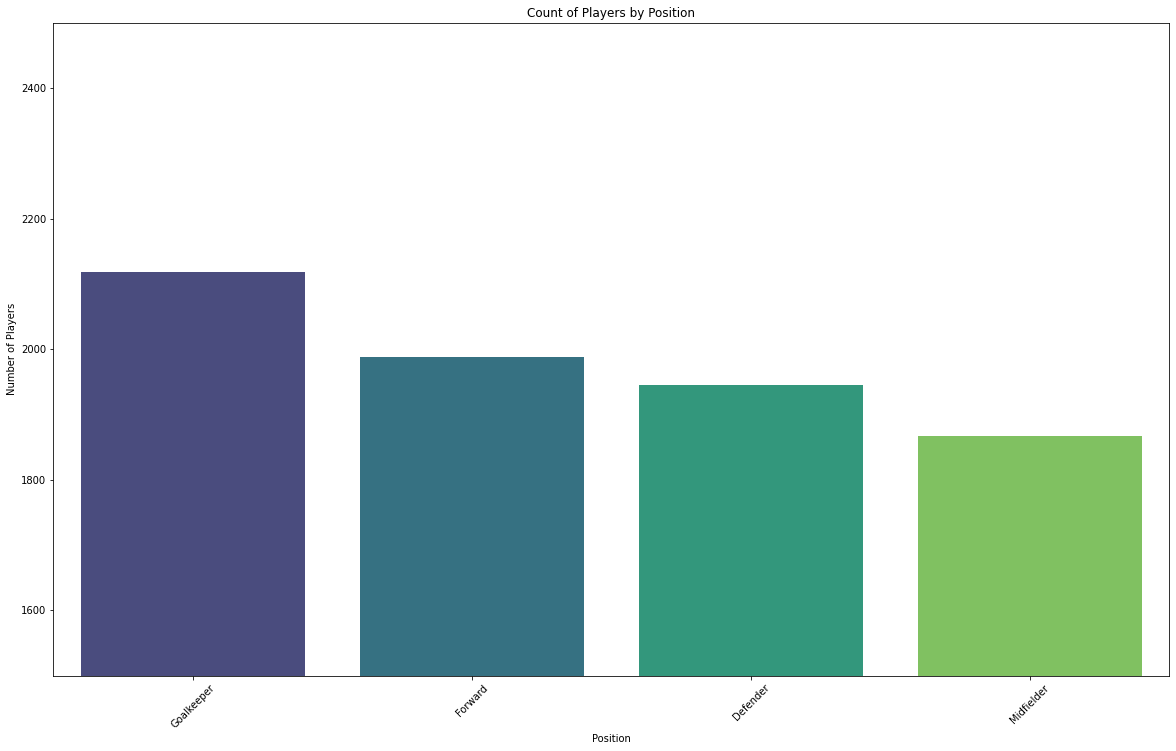

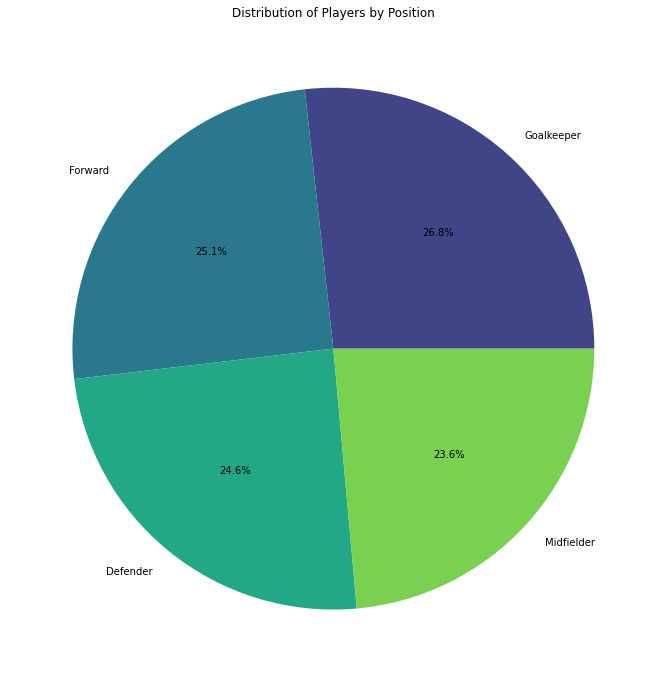

In [12]:
plt.figure(figsize=(20, 12))
sns.barplot(x=position_counts.index, y=position_counts.values, palette="viridis")
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.title('Count of Players by Position')
plt.ylim(1500, 2500)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 12), facecolor='white')
plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(position_counts)))
plt.title('Distribution of Players by Position')
plt.show()



# Problem Statement 3: Data Ingestion Strategies

In [ ]:
"""Problem Statement 3:   Design and implement a data ingestion pipeline that supports incremental data loading. Optimize storage by using data partitioning and indexing strategies. Implement logging and monitoring to track the performance and reliability of the ingestion process. Utilize Python, pandas, and SQL for implementation.
   -   Additional Complexity:   Use parallel processing to enhance the data ingestion performance.
"""

In [15]:
cleaned_data = data.drop_duplicates()

In [21]:
data = pd.read_csv('cleaned_sports_dataset.csv')
cleaned_data = data.drop_duplicates()
player_details_data = cleaned_data[['PU_ID', 'Age', 'Height', 'Weight']].drop_duplicates()
player_performance_data = cleaned_data[['PU_ID', 'Team', 'Season', 'Goals', 'Assists', 'YellowCards', 'RedCards',
                                        'PassCompletionRate', 'DistanceCovered', 'Sprints', 'ShotsOnTarget',
                                        'TacklesWon', 'CleanSheets']].drop_duplicates(subset=['PU_ID'])
health_data = cleaned_data[['PU_ID', 'Season', 'PlayerFatigue', 'MatchPressure', 'InjuryHistory']].drop_duplicates()
training_data = cleaned_data[['PU_ID', 'Season', 'TrainingHours', 'FatigueInjuryCorrelation', 'PressurePerformanceImpact', 'EffectiveTraining']].drop_duplicates()

player_details_data.to_csv('player_details.csv', index=False)
player_performance_data.to_csv('player_performance.csv', index=False)
health_data.to_csv('health.csv', index=False)
training_data.to_csv('training.csv', index=False)

print("Schema-specific CSV files saved.")

Schema-specific CSV files saved.


In [22]:
conn = sqlite3.connect('football.db')

player_detail_schema = """
CREATE TABLE IF NOT EXISTS PlayerDetail (
    PU_ID INTEGER PRIMARY KEY,
    Age INTEGER,
    Height REAL,
    Weight REAL
);
"""

player_performance_schema = """
CREATE TABLE IF NOT EXISTS PlayerPerformance (
    PU_ID INTEGER PRIMARY KEY,
    Team TEXT,
    Season INTEGER,
    Goals INTEGER,
    Assists INTEGER,
    YellowCards INTEGER,
    RedCards INTEGER,
    PassCompletionRate REAL,
    DistanceCovered REAL,
    Sprints INTEGER,
    ShotsOnTarget INTEGER,
    TacklesWon INTEGER,
    CleanSheets INTEGER,
    FOREIGN KEY (PU_ID) REFERENCES PlayerDetail(PU_ID)
);
"""

health_schema = """
CREATE TABLE IF NOT EXISTS Health (
    PU_ID INTEGER,
    Season INTEGER,
    PlayerFatigue REAL,
    MatchPressure REAL,
    InjuryHistory REAL,
    FOREIGN KEY (PU_ID) REFERENCES PlayerDetail(PU_ID)
);
"""

training_schema = """
CREATE TABLE IF NOT EXISTS Training (
    PU_ID INTEGER,
    Season INTEGER,
    TrainingHours REAL,
    FatigueInjuryCorrelation REAL,
    PressurePerformanceImpact REAL,
    EffectiveTraining REAL,
    FOREIGN KEY (PU_ID) REFERENCES PlayerDetail(PU_ID)
);
"""

conn.execute(player_detail_schema)
conn.execute(player_performance_schema)
conn.execute(health_schema)
conn.execute(training_schema)
conn.commit()

player_details_data = pd.read_csv('player_details.csv')
player_performance_data = pd.read_csv('player_performance.csv')
health_data = pd.read_csv('health.csv')
training_data = pd.read_csv('training.csv')

def insert_data_into_table(table_name, data):
    conn = sqlite3.connect('football.db')
    try:
        data.to_sql(table_name, conn, if_exists='append', index=False)
    except IntegrityError:
        pass
    finally:
        conn.commit()
        conn.close()
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor() as executor:
    futures = []
    futures.append(executor.submit(insert_data_into_table, 'PlayerDetail', player_details_data))
    futures.append(executor.submit(insert_data_into_table, 'PlayerPerformance', player_performance_data))
    futures.append(executor.submit(insert_data_into_table, 'Health', health_data))
    futures.append(executor.submit(insert_data_into_table, 'Training', training_data))

    for future in futures:
        future.result()

print("Data insertion into SQLite completed.")


Data insertion into SQLite completed.


In [36]:
player_details_data = pd.read_csv('player_details.csv')
player_performance_data = pd.read_csv('player_performance.csv')
health_data = pd.read_csv('health.csv')
training_data = pd.read_csv('training.csv')

sql_script = """-- MySQL dump 10.13  Distrib 8.0.19, for osx10.14 (x86_64)
--
-- Host: 127.0.0.1    Database: football
-- ------------------------------------------------------
-- Server version	8.0.19-debug

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!50503 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;
SET @old_autocommit=@@autocommit;

--
-- Create new Database: `football`
--
CREATE DATABASE IF NOT EXISTS `football` DEFAULT CHARACTER SET utf8mb4;
USE `football`;

"""

def generate_sql(table_name, df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    sql_script = f"DROP TABLE IF EXISTS {table_name};\n"
    sql_script += f"CREATE TABLE {table_name} (\n"
    for column in non_numeric_cols:
        sql_script += f"    {column} TEXT,\n"
    for column in numeric_cols:
        sql_script += f"    {column} REAL,\n"
    sql_script = sql_script.rstrip(',\n') + "\n);\n"
    for _, row in df.iterrows():
        insert_statement = f"INSERT INTO {table_name} VALUES ("
        for value in row.values:
            if isinstance(value, str):
                insert_statement += f"'{value}', "
            else:
                insert_statement += f"{value}, "
        insert_statement = insert_statement.rstrip(', ') + ");\n"
        sql_script += insert_statement

    return sql_script

sql_script += generate_sql('player_details', player_details_data)
sql_script += generate_sql('player_performance', player_performance_data)
sql_script += generate_sql('health', health_data)
sql_script += generate_sql('training', training_data)

with open('football.sql', 'w') as f:
    f.write(sql_script)

print("MySQL script created: football.sql")


MySQL script created: football.sql


In [37]:
logging.basicConfig(filename='data_ingestion.log', level=logging.INFO, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

def insert_data_into_table_with_logging(table_name, data):
    conn = sqlite3.connect('football.db')
    start_time = time.time()
    try:
        data.to_sql(table_name, conn, if_exists='append', index=False)
        logging.info(f"Inserted data into {table_name} successfully.")
    except IntegrityError as e:
        logging.error(f"Error inserting data into {table_name}: {e}")
    finally:
        conn.commit()
        conn.close()
    end_time = time.time()
    logging.info(f"Time taken to insert data into {table_name}: {end_time - start_time} seconds.")

with ThreadPoolExecutor() as executor:
    futures = []
    futures.append(executor.submit(insert_data_into_table_with_logging, 'PlayerDetail', player_details_data))
    futures.append(executor.submit(insert_data_into_table_with_logging, 'PlayerPerformance', player_performance_data))
    futures.append(executor.submit(insert_data_into_table_with_logging, 'Health', health_data))
    futures.append(executor.submit(insert_data_into_table_with_logging, 'Training', training_data))
    for future in futures:
        future.result()

print("Data insertion with logging completed.")

Data insertion with logging completed.


## later basis using workbench

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='wajith',
    password='1234',
    database='football'
)
cursor = conn.cursor()
player_details_data = pd.read_csv('player_details.csv')
player_performance_data = pd.read_csv('player_performance.csv')
health_data = pd.read_csv('health.csv')
training_data = pd.read_csv('training.csv')

def insert_data_into_table(table_name, data):
    try:
        data.to_sql(table_name, conn, if_exists='append', index=False)
        logging.info(f"Data inserted into {table_name}")
    except Exception as e:
        logging.error(f"Error inserting data into {table_name}: {e}")
    finally:
        conn.commit()
with ThreadPoolExecutor() as executor:
    futures = []
    futures.append(executor.submit(insert_data_into_table, 'player_details', player_details_data))
    futures.append(executor.submit(insert_data_into_table, 'player_performance', player_performance_data))
    futures.append(executor.submit(insert_data_into_table, 'health', health_data))
    futures.append(executor.submit(insert_data_into_table, 'training', training_data))

    for future in futures:
        future.result()

logging.info("Data insertion into MySQL completed.")
conn.close()

In [ ]:
import mysql.connector
from concurrent.futures import ThreadPoolExecutor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='wajith',
    password='1234',
    database='football'
)
cursor = conn.cursor()
player_details_data = pd.read_csv('player_details.csv')
player_performance_data = pd.read_csv('player_performance.csv')
health_data = pd.read_csv('health.csv')
training_data = pd.read_csv('training.csv')

def get_last_update_time(table_name):
    cursor.execute(f"SELECT MAX(last_updated) FROM {table_name}")
    return cursor.fetchone()[0]

def filter_new_data(data, last_update_time):
    if last_update_time:
        data['last_updated'] = pd.to_datetime(data['last_updated'])
        return data[data['last_updated'] > last_update_time]
    return data

def insert_data_into_table(table_name, data):
    try:
        last_update_time = get_last_update_time(table_name)
        new_data = filter_new_data(data, last_update_time)
        new_data.to_sql(table_name, conn, if_exists='append', index=False)
        logging.info(f"Data inserted into {table_name}")
    except Exception as e:
        logging.error(f"Error inserting data into {table_name}: {e}")
    finally:
        conn.commit()
with ThreadPoolExecutor() as executor:
    futures = []
    futures.append(executor.submit(insert_data_into_table, 'player_details', player_details_data))
    futures.append(executor.submit(insert_data_into_table, 'player_performance', player_performance_data))
    futures.append(executor.submit(insert_data_into_table, 'health', health_data))
    futures.append(executor.submit(insert_data_into_table, 'training', training_data))

    for future in futures:
        future.result()

logging.info("Incremental data insertion into MySQL completed.")
conn.close()


# Problem Statement 4 : Pass Completion Rate vs. Assists

In [ ]:
"""-   Problem Statement 4:   Analyze the relationship between pass completion rate and assists. Create a scatter plot and identify outliers using advanced outlier detection methods like DB-SCAN or Isolation Forest. Plot a line of best fit and use regression analysis to model the relationship. Evaluate the model using appropriate metrics.
   -   Additional Complexity:   Implement cross-validation to ensure the robustness of your regression model."""

In [40]:
df_data = pd.read_csv('cleaned_sports_dataset.csv')
data = df_data[['PassCompletionRate', 'Assists']]
data.dropna(inplace=True)
X = data[['PassCompletionRate']]
y = data['Assists']

C:\Users\Wajith Ali\AppData\Local\Temp\ipykernel_12724\3286464311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [41]:
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores
print("Cross-validation Scores (Mean Squared Error):")
print(mse_scores)

Cross-validation Scores (Mean Squared Error):
[31.96986952 34.04686811 32.74138756 34.65139173 33.36466282]


In [42]:
model.fit(X, y)
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print("\nMean Squared Error on Entire Dataset:", mse)


Mean Squared Error on Entire Dataset: 33.32690943809759


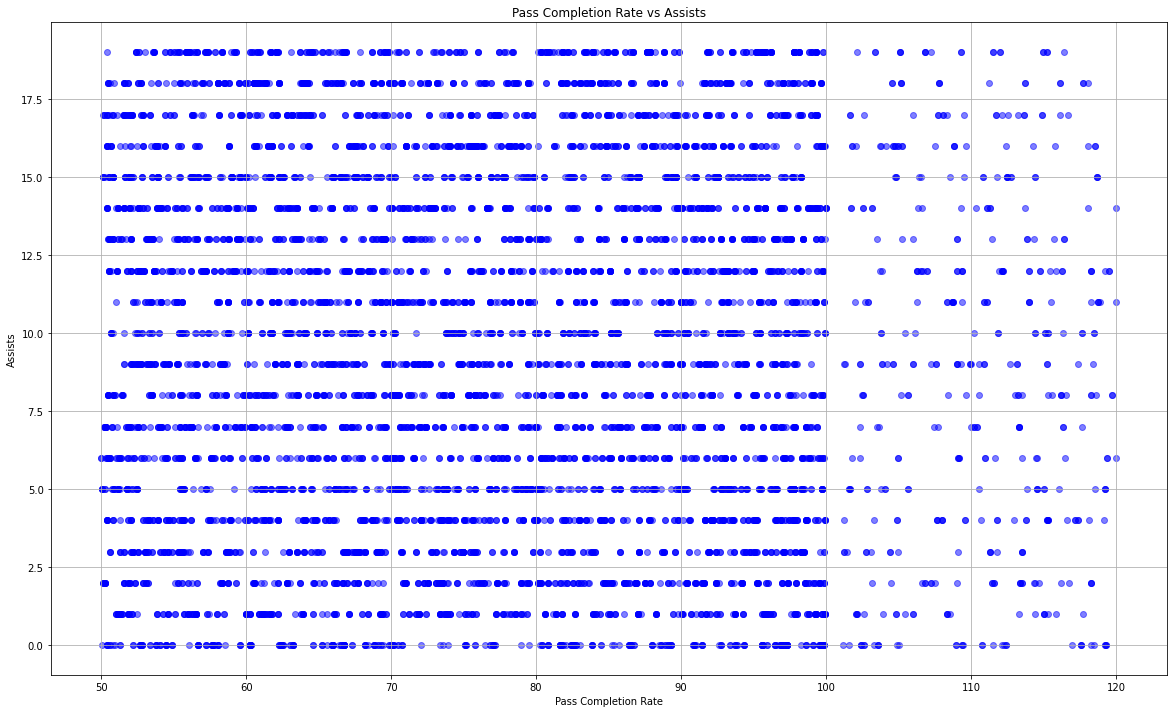

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
plt.scatter(df_data['PassCompletionRate'], df_data['Assists'], color='blue', alpha=0.5)
plt.title('Pass Completion Rate vs Assists')
plt.xlabel('Pass Completion Rate')
plt.ylabel('Assists')
plt.grid(True)
plt.show()

C:\Users\Wajith Ali\AppData\Local\Temp\ipykernel_12724\299066692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Outlier'] = outliers


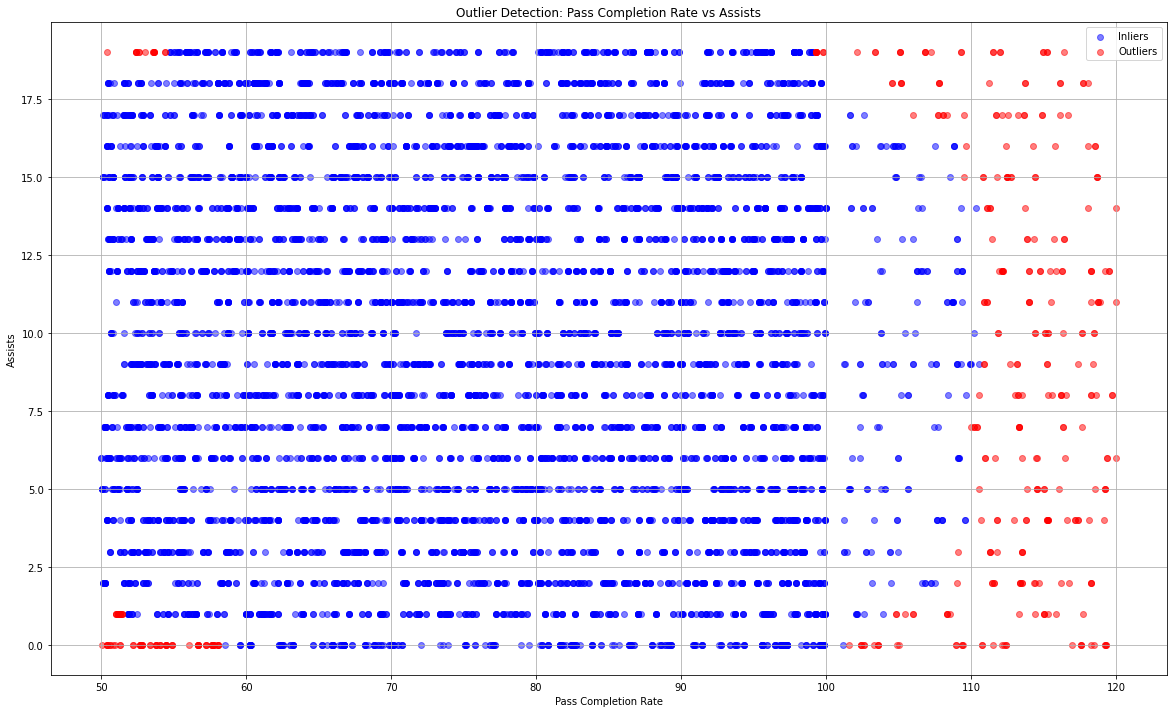

In [45]:
iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(data)
data['Outlier'] = outliers
plt.figure(figsize=(20, 12))
plt.scatter(data[data['Outlier'] == 1]['PassCompletionRate'], data[data['Outlier'] == 1]['Assists'], color='blue', alpha=0.5, label='Inliers')
plt.scatter(data[data['Outlier'] == -1]['PassCompletionRate'], data[data['Outlier'] == -1]['Assists'], color='red', alpha=0.5, label='Outliers')
plt.title('Outlier Detection: Pass Completion Rate vs Assists')
plt.xlabel('Pass Completion Rate')
plt.ylabel('Assists')
plt.legend()
plt.grid(True)
plt.show()

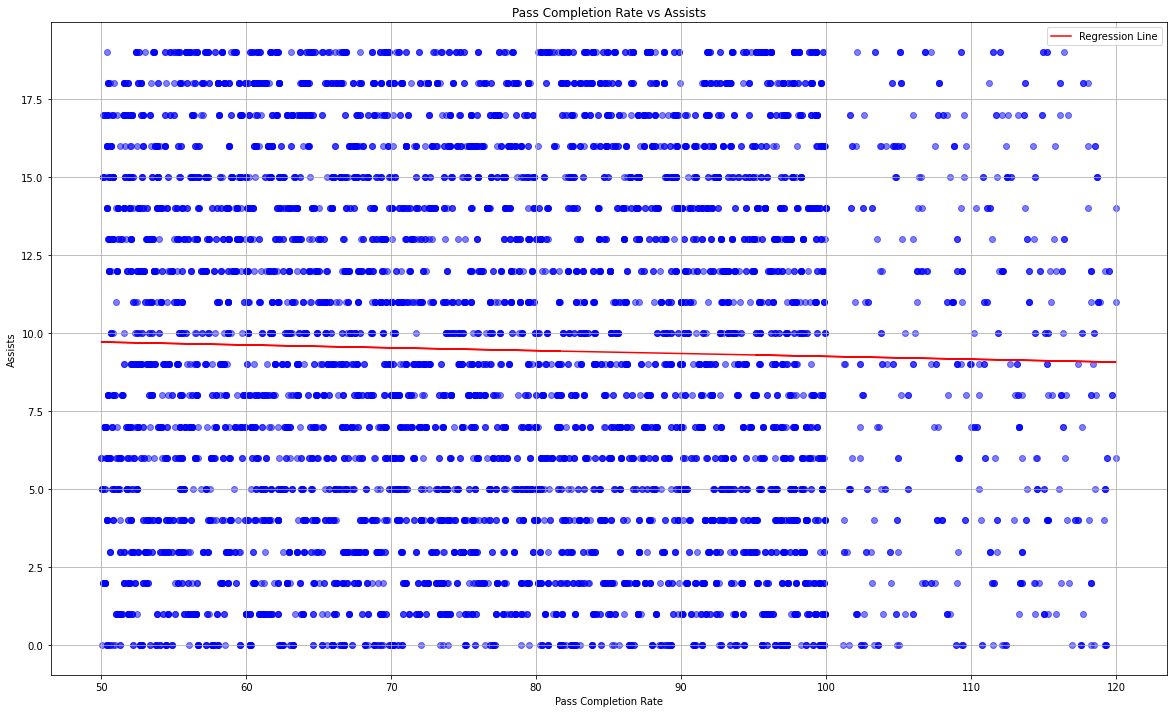

In [46]:
slope, intercept, r_value, p_value, std_err = linregress(data['PassCompletionRate'], data['Assists'])
regression_line = intercept + slope * data['PassCompletionRate']
plt.figure(figsize=(20, 12))
plt.scatter(data['PassCompletionRate'], data['Assists'], color='blue', alpha=0.5)
plt.plot(data['PassCompletionRate'], regression_line, color='red', label='Regression Line')
plt.title('Pass Completion Rate vs Assists')
plt.xlabel('Pass Completion Rate')
plt.ylabel('Assists')
plt.legend()
plt.grid(True)
plt.show()

# Problem Statement 5 : Advanced Data Transformations

In [ ]:
"""Problem Statement 5:   Perform complex transformations on the dataset, including feature engineering to create new meaningful features. Implement additional strategies for data optimization, such as data normalization and dimensionality reduction.
   -   Additional Complexity:   Use machine learning techniques for feature selection and extraction.
"""

In [50]:
data = pd.read_csv('cleaned_sports_dataset.csv')
data['GoalsPerGame'] = data['Goals'] / data['Season']
data['AssistsPerGame'] = data['Assists'] / data['Season']
data['CardsPerGame'] = (data['YellowCards'] + data['RedCards']) / data['Season']
data.dropna(subset=['GoalsPerGame', 'AssistsPerGame', 'CardsPerGame'], inplace=True)
print("Data after feature engineering:")
print(data[['GoalsPerGame', 'AssistsPerGame', 'CardsPerGame']].head())

Data after feature engineering:
   GoalsPerGame  AssistsPerGame  CardsPerGame
0      0.005440        0.000989      0.003462
1      0.000991        0.007925      0.004953
2      0.006436        0.000495      0.002970
3      0.002967        0.003956      0.001484
4      0.012871        0.001485      0.002970


In [51]:
features_to_normalize = ['Height', 'Weight', 'PassCompletionRate', 'DistanceCovered', 'Sprints', 'ShotsOnTarget', 
                         'TacklesWon', 'CleanSheets', 'GoalsPerGame', 'AssistsPerGame', 'CardsPerGame']
scaler = MinMaxScaler()
data[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])
print("Normalized Data Head:\n", data[features_to_normalize].head())

Normalized Data Head:
      Height    Weight  PassCompletionRate  DistanceCovered   Sprints  \
0  0.040757  0.078336            0.451986            0.588  0.424242   
1  0.043183  0.029587            0.375536            0.065  0.171717   
2  0.238040  0.004896            0.710632            0.352  0.585859   
3  0.311790  0.151671            0.020292            0.224  0.616162   
4  0.192431  0.077178            0.463275            0.921  0.808081   

   ShotsOnTarget  TacklesWon  CleanSheets  GoalsPerGame  AssistsPerGame  \
0       0.285714    0.758621     0.666667      0.004068        0.105107   
1       0.428571    0.931034     0.666667      0.000741        0.842105   
2       0.357143    0.103448     0.444444      0.004812        0.052606   
3       0.214286    0.413793     0.888889      0.002219        0.420428   
4       0.857143    0.655172     0.222222      0.009625        0.157817   

   CardsPerGame  
0      0.537663  
1      0.769231  
2      0.461310  
3      0.230427  
4  

Explained Variance Ratio:
 [0.14814302 0.14149964 0.13556437 0.12501172 0.11991217 0.11302768
 0.08251073 0.07715049 0.02857514 0.02642718 0.00217786]
Cumulative Variance:
 [0.14814302 0.28964266 0.42520703 0.55021876 0.67013093 0.7831586
 0.86566933 0.94281982 0.97139496 0.99782214 1.        ]


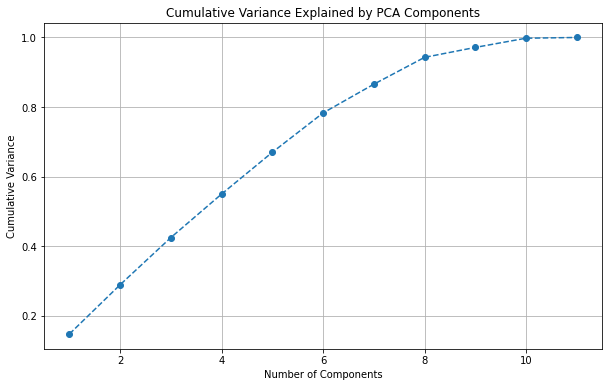

In [53]:
pca = PCA(n_components=None) 
pca_features = pca.fit_transform(data[features_to_normalize])
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
print("Explained Variance Ratio:\n", explained_variance_ratio)
print("Cumulative Variance:\n", cumulative_variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

In [54]:
n_components_to_retain = 5  
pca = PCA(n_components=n_components_to_retain)
pca_features = pca.fit_transform(data[features_to_normalize])
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components_to_retain)])
print("Selected PCA Components Head:\n", pca_df.head())

Selected PCA Components Head:
         PC1       PC2       PC3       PC4       PC5
0 -0.135385 -0.235847  0.139408  0.316257 -0.330634
1 -0.154602 -0.045339 -0.546545  0.459846  0.301918
2  0.128613 -0.266760  0.574399 -0.024947  0.109265
3 -0.340084 -0.317884  0.129920  0.092162  0.260071
4  0.273917  0.352941  0.290083 -0.108162 -0.521549


In [55]:
data.to_csv('normalized_data.csv', index=False)
pca_df.to_csv('selected_pca_data.csv', index=False)
print("Data saved to CSV files.")

Data saved to CSV files.


In [56]:
sql_script = """-- MySQL dump 10.13  Distrib 8.0.19, for osx10.14 (x86_64)
--
-- Host: 127.0.0.1    Database: transformed_football
-- ------------------------------------------------------
-- Server version	8.0.19-debug

/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;
/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;
/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;
/*!50503 SET NAMES utf8mb4 */;
/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;
/*!40103 SET TIME_ZONE='+00:00' */;
/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;
/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;
/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;
/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;
SET @old_autocommit=@@autocommit;

--
-- Create new Database: `transformed_football`
--
CREATE DATABASE IF NOT EXISTS `transformed_football` DEFAULT CHARACTER SET utf8mb4;
USE `transformed_football`;

--
-- Table structure for table `normalized_data`
--
CREATE TABLE normalized_data (
    Height REAL,
    Weight REAL,
    PassCompletionRate REAL,
    DistanceCovered REAL,
    Sprints REAL,
    ShotsOnTarget REAL,
    TacklesWon REAL,
    CleanSheets REAL,
    GoalsPerGame REAL,
    AssistsPerGame REAL,
    CardsPerGame REAL
);

--
-- Table structure for table `selected_pca_data`
--
CREATE TABLE selected_pca_data (
    PC1 REAL,
    PC2 REAL,
    PC3 REAL,
    PC4 REAL,
    PC5 REAL
);

"""

normalized_data = pd.read_csv('normalized_data.csv')
insert_statement = f"INSERT INTO normalized_data VALUES\n"
for _, row in normalized_data.iterrows():
    row_values = [f"{value}" for value in row.values]
    insert_statement += f"    ({', '.join(row_values)}),\n"
insert_statement = insert_statement.rstrip(',\n') + ";\n\n"
sql_script += insert_statement
selected_pca_data = pd.read_csv('selected_pca_data.csv')
insert_statement = f"INSERT INTO selected_pca_data VALUES\n"
for _, row in selected_pca_data.iterrows():
    row_values = [f"{value}" for value in row.values]
    insert_statement += f"    ({', '.join(row_values)}),\n"
insert_statement = insert_statement.rstrip(',\n') + ";\n\n"
sql_script += insert_statement
with open('transformed_football.sql', 'w') as f:
    f.write(sql_script)

print("SQL script saved to 'transformed_football.sql'.")

SQL script saved to 'transformed_football.sql'.


# Problem Statement 6 : Data Warehousing

In [ ]:
"""-   Problem Statement 6:   Design and implement a data warehouse schema using advanced SQL features like window functions and CTEs (Common Table Expressions). Store the transformed data efficiently and ensure it supports complex analytical queries. Implement data security and access control mechanisms.
   -   Additional Complexity:   Optimize the data warehouse for performance using techniques like indexing, partitioning, and materialized views.
"""

In [60]:
# sql

# Problem Statement 7 : Team Goals Analysis

In [ ]:
"""-   Problem Statement 7:   Identify the team with the highest number of goals. Create a horizontal bar plot and a stacked bar chart. Perform a time series analysis to understand trends in goal scoring over the season. Identify the top goal scorer in that team and analyze their performance metrics over time.
   -   Additional Complexity:   Use advanced visualization tools like Plotly or D3.js for interactive visualizations."""

In [64]:
data = pd.read_csv('cleaned_sports_dataset.csv')
team_goals = data.groupby('Team')['Goals'].sum()
team_with_highest_goals = team_goals.idxmax()
print(f"Team with the highest number of goals: {team_with_highest_goals}")

Team with the highest number of goals: Team B


In [68]:
fig1 = px.bar(
    team_goals.reset_index(), 
    x='Goals', 
    y='Team', 
    orientation='h', 
    title='Total Goals by Team'
)
fig1.show()

In [69]:
season_team_goals = data.groupby(['Season', 'Team'])['Goals'].sum().reset_index()
fig2 = px.bar(
    season_team_goals, 
    x='Season', 
    y='Goals', 
    color='Team', 
    title='Goals by Team and Season', 
    barmode='stack'
)
fig2.show()

In [70]:
team_data = data[data['Team'] == team_with_highest_goals]
goals_over_time = team_data.groupby('Season')['Goals'].sum().reset_index()
fig3 = px.line(
    goals_over_time, 
    x='Season', 
    y='Goals', 
    title=f'Goals Over Time for {team_with_highest_goals}'
)
fig3.show()

In [71]:
top_scorer = team_data.loc[team_data['Goals'].idxmax()]
print(f"Top goal scorer in {team_with_highest_goals}: {top_scorer['Player']}")
top_scorer_performance = team_data[team_data['Player'] == top_scorer['Player']]
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=top_scorer_performance['Season'], y=top_scorer_performance['Goals'], mode='lines+markers', name='Goals'))
fig4.add_trace(go.Scatter(x=top_scorer_performance['Season'], y=top_scorer_performance['Assists'], mode='lines+markers', name='Assists'))
fig4.update_layout(title=f'Performance Metrics of {top_scorer["Player"]} Over Time', xaxis_title='Season', yaxis_title='Count')
fig4.show()

Top goal scorer in Team B: Player C


# Problem Statement 8 : Reporting and Visualization

In [ ]:
"""Problem Statement 8:   Develop interactive dashboards and visualizations using tools like Power BI, Tableau, or custom web applications using Dash or Streamlit. Create reports that provide insights into player performance, team strategies, and potential areas for improvement. Incorporate advanced analytics like clustering and predictive modeling to forecast future performance.
   -   Additional Complexity:   Integrate real-time data feeds to update the dashboards dynamically.
"""

In [11]:
import pygwalker as pg

In [12]:
pg.__version__

'0.4.8.9'

In [18]:
player_details = pd.read_csv('player_details.csv')
player_performance = pd.read_csv('player_performance.csv')
health = pd.read_csv('health.csv')
training = pd.read_csv('training.csv')

merged_data = pd.merge(player_performance, player_details, on='PU_ID')
print(merged_data.head(10))

   PU_ID    Team  Season  Goals  Assists  YellowCards  RedCards  \
0      0  Team C    2022   11.0      2.0            4         3   
1      1  Team C    2019    2.0     16.0            8         2   
2      3  Team C    2020   13.0      1.0            3         3   
3      3  Team C    2020   13.0      1.0            3         3   
4      4  Team C    2022    6.0      8.0            1         2   
5      9  Team A    2020   26.0      3.0            4         2   
6     11  Team A    2021   27.0     12.0            1         0   
7     13  Team A    2021    0.0     12.0            9         1   
8     14  Team C    2019   22.0      4.0            0         4   
9     17  Team C    2021   23.0     13.0            0         3   

   PassCompletionRate  DistanceCovered  Sprints  ShotsOnTarget  TacklesWon  \
0               81.64            10.88       42              4          22   
1               76.29             5.65       17              6          27   
2               99.74       

In [19]:
pg.walk(merged_data)

Box(children=(HTML(value='<div id="ifr-pyg-00061a8217a79ef65ViIGSk0Esbq4anZ" style="height: auto">\n    <head>…